In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Setup
-----

In [2]:
data = pd.read_csv('./winequalityred.csv', sep=';')
features = data.columns.difference(['quality'])
X, y = data[features].values, data['quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"""train features: {X_train.shape}, train output: {y_train.shape}
test features: {X_test.shape}, test output: {y_test.shape}""")

train features: (1279, 11), train output: (1279,)
test features: (320, 11), test output: (320,)


## Regression equations and functions 
-----

In [3]:
def y_hat(X, beta):
    return np.sum(beta*X, axis=1)

def RSS(beta, X, y):
    return np.sum((y-y_hat(X,beta))**2)

## Optimize the model
------

Q1
>Notice that from the table below, some features are associated with negative coefficients, for example, chlorides, citric acid, pH etc. Some features are associated with positive coefficients, like, alcohol, density, fixed acidity etc. This means that, an increase in the alcohol would have a positive effect on the quality of the wine, and an increase in chlorides would likely have a negative effect on the quality. For example, one unit increase in alcohol will cause 0.29 unit increase in the quality of the wine, same goes for the other predictor variables. 
>
>By looking at the coefficients, we can see that density is the most important feature for the regression model as it carries the largest coefficient. Further, the magnitude of the features in X may not affect the results since for features with large magnitude, their coefficients would likely be less significant than the features with small magnitude. The coefficients will adjust the final contribution of the features to the result. 


In [4]:
beta0 = np.random.normal(0, 1, X_train.shape[1])
res = minimize(fun=RSS, x0=beta0, args=(X_train, y_train))
beta_hat = res.x
df_beta = pd.DataFrame(list(zip(features, beta_hat)), columns=['feature', 'coefficient'])
df_beta.set_index('feature')

,coefficient
feature,
alcohol,0.295313
chlorides,-1.824269
citric acid,-0.142352
density,4.292255
fixed acidity,0.009774
free sulfur dioxide,0.005777
pH,-0.464661
residual sugar,0.000368
sulphates,0.822091


In [5]:
X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())

res_norm = minimize(fun=RSS, x0=beta0, args=(X_train_norm, y_train))
beta_hat_norm = res_norm.x

Q2
> The RSS for test dataset is 125.1, a lot smaller compared to the RSS for train dataset, which is 542.7 
>
>The RSS does change after the features in X having been normalized, the test RSS increases to 135.9; however, the RSS for the train dataset does not change 

In [6]:
RSS_train = RSS(beta_hat, X_train, y_train)
RSS_test = RSS(beta_hat, X_test, y_test)

print(f'train RSS: {RSS_train}, test RSS: {RSS_test}')

train RSS: 542.6975235743919, test RSS: 125.0661874703074


In [7]:
RSS_train_norm = RSS(beta_hat_norm, X_train_norm, y_train)
RSS_test_norm = RSS(beta_hat_norm, X_test_norm, y_test)

print(f'normalized train RSS: {RSS_train_norm}, normalized test RSS: {RSS_test_norm}')

normalized train RSS: 542.6975235855646, normalized test RSS: 135.8731127655568


Q3
> Notice that the RSS on test dataset does not change with different initial values of $\beta$. I have tried $\beta$ with different magnitudes, ranging from (1,10) to (1000,10000), and the RSS for the test dataset always converges to 125. Therefore, with different $\beta$'s, the end result would not change.

In [8]:
beta_limit = np.geomspace(1,10000,num=5)
beta0s = [np.random.normal(beta_limit[i], 
                           beta_limit[i+1], 
                           X_train.shape[1]) 
              for i in range(len(beta_limit)-1)]

for i, beta0 in enumerate(beta0s):
    print(f'for beta0 between {beta_limit[i]} and {beta_limit[i+1]}')
    res = minimize(fun=RSS, x0=beta0, args=(X_train, y_train))
    beta_hat = res.x
    RSS_test = RSS(beta_hat, X_test, y_test)
    print(f'\tRSS for test dataset is {RSS_test}')

for beta0 between 1.0 and 10.0
	RSS for test dataset is 125.0661854027641
for beta0 between 10.0 and 100.0
	RSS for test dataset is 125.0661898000281
for beta0 between 100.0 and 1000.0
	RSS for test dataset is 125.06618918202712
for beta0 between 1000.0 and 10000.0
	RSS for test dataset is 125.06618905790364


Q4

>Notice from the printouts below, different solver methods might yield different RSS for the test dataset. For example, using COBYLA the RSS is 2447.9, the RSS is 215.3 by using Nelder-Mead, and the RSS is 138.7 by using TNC. Therefore, using different solver methods might yield different end results

In [9]:
solvers = ['Nelder-Mead',
           'Powell',
           'CG',
           'BFGS',
           'L-BFGS-B',
           'TNC',
           'COBYLA',
           'SLSQP',
           'trust-constr']

for solver in solvers:
    beta0 = np.random.normal(0, 1, X_train.shape[1])
    print(f'solver: {solver}')
    res = minimize(fun=RSS, x0=beta0, args=(X_train, y_train), method=solver)
    beta_hat = res.x
    RSS_test = RSS(beta_hat, X_test, y_test)
    print(f'\tRSS for test dataset is {RSS_test}')

solver: Nelder-Mead
	RSS for test dataset is 215.30562778483807
solver: Powell
	RSS for test dataset is 125.06436929756526
solver: CG
	RSS for test dataset is 125.06634229096485
solver: BFGS
	RSS for test dataset is 125.06618945680047
solver: L-BFGS-B
	RSS for test dataset is 125.08060835571838
solver: TNC
	RSS for test dataset is 138.7222032126652
solver: COBYLA
	RSS for test dataset is 2447.9100906092835
solver: SLSQP
	RSS for test dataset is 125.06622228040257
solver: trust-constr
	RSS for test dataset is 125.06619672915168


## Regularizing the model
____

Q1
> The RSS for both train and test datasets doesn't change much. The difference is very insignificant assuming $\lambda$ = 0.01. RSS for train dataset is 542.7 and RSS for test dataset is 125.1

In [10]:
def RSSL2(beta, X, y, lmbda=0.01):
    return np.sum((y-y_hat(X,beta))**2) + lmbda*np.sum(beta**2)

res_ridge = minimize(fun=RSSL2, x0=beta0, args=(X_train, y_train))
beta_hat = res_ridge.x
RSS_train = RSS(beta_hat, X_train, y_train)
RSS_test = RSS(beta_hat, X_test, y_test)
print(f'RSS for train dataset: {RSS_train}, RSS for test dataset: {RSS_test}')

RSS for train dataset: 542.7001792866943, RSS for test dataset: 125.09934905395255


Q2

> As you can see from the graph below, RSS does not converge when $\lambda$ gets bigger. Instead, it's increasing, so it would not be possible to tune $\lambda$ to obtain the best result in the test data by using Ridge Regression. 

In [11]:
lmbdas = np.geomspace(0.1, 10, num=100)
RSS_ridges = np.empty(0)

for lmbda in lmbdas:
    res_ridge = minimize(fun=RSSL2, x0=beta0, args=(X_train, y_train, lmbda))
    beta_hat = res_ridge.x
    RSS_test = RSS(beta_hat, X_test, y_test)
    RSS_ridges = np.append(RSS_ridges, RSS_test)

Text(0.5, 1.0, 'L2 Regularization')

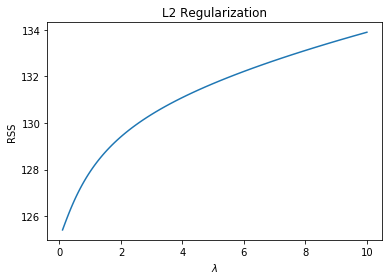

In [12]:
plt.plot(lmbdas, RSS_ridges)
plt.xlabel('$\lambda$')
plt.ylabel('RSS')
plt.title('L2 Regularization')

Q3

> The RSS of LASSO Regression on both the train and test datasets is almost the same as regular regression. The RSS on train dataset is 542.7, and the RSS on test dataset is 125.1. The RSS for LASSO regression still doesn't converge when different values for $\lambda$ were applied. Therefore, you can't really tune $\lambda$ to get the best result as shown in the plot below. 

In [13]:
def RSSL1(beta, X, y, lmbda=0.01):
    return 0.5*np.sum((y-y_hat(X,beta))**2) + lmbda*np.sum(np.abs(beta))

res_lasso = minimize(fun=RSSL1, x0=beta0, args=(X_train, y_train))
beta_hat = res_lasso.x
RSS_train = RSS(beta_hat, X_train, y_train)
RSS_test = RSS(beta_hat, X_test, y_test)
print(f'RSS for train dataset: {RSS_train}, RSS for test dataset: {RSS_test}')

RSS for train dataset: 542.6977968125891, RSS for test dataset: 125.08037713635298


In [14]:
lmbdas = np.geomspace(0.01, 10, num=100)
RSS_lassos = np.empty(0)

for lmbda in lmbdas:
    res_lasso = minimize(fun=RSSL1, x0=beta0, args=(X_train, y_train, lmbda))
    beta_hat = res_lasso.x
    RSS_test = RSS(beta_hat, X_test, y_test)
    RSS_lassos = np.append(RSS_lassos, RSS_test)

Text(0.5, 1.0, 'L1 Regularization')

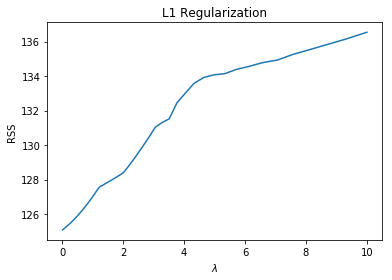

In [15]:
plt.plot(lmbdas, RSS_lassos)
plt.xlabel('$\lambda$')
plt.ylabel('RSS')
plt.title('L1 Regularization')

Q4
> The magnitude of the features in X may affect the results with regularization. Since regularization puts constraints on the magnitude of the coefficients associated with each variable, features with different magnitude will be associated with coefficients with different magnitude, thus it will yield different RSS. 

In [16]:
res_lasso_norm = minimize(fun=RSSL1, x0=beta0, args=(X_train_norm, y_train))
beta_hat_norm = res_lasso_norm.x
RSS_train_norm = RSS(beta_hat_norm, X_train_norm, y_train)
RSS_test_norm = RSS(beta_hat_norm, X_test_norm, y_test)
print(f'RSS for train dataset: {RSS_train_norm}, RSS for test dataset: {RSS_test_norm}')

RSS for train dataset: 555.2223800211117, RSS for test dataset: 139.78663109167903
